In [1]:
from modelzipper.tutils import *
import transformers
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
from collections import defaultdict
from pprint import pprint
import pandas as pd
import multiprocessing as mp
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import MultipleLocator

/data/anaconda3/envs/zecheng/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModelZipper is ready for launch🚀 | Current Version🦄 >>> 0.2.7 <<< | AOE Time🕒 2024-08-21 03:12:49


##### [优先执行 --- 所有的统计主函数都写在这里,没有执行文件] 

In [4]:
def process_score_each(reference_score, filter_strategy='Partial Correct'):
    # 处理每个深度和ctx的分数
    stat_ref_scores, stat_recall_scores = {}, {}
    head_num = len(reference_score.keys())
    with tqdm(total=len(reference_score.keys())) as pbar:
        for key in reference_score.keys():
            item = reference_score[key] # 每个head的分数
            for i, instance in enumerate(item): # 每个ctx的分数
                ctx, depth = get_depth_and_ctx(i)
                step_values, recall_value = instance[0], instance[1]
                
                if filter_strategy.lower() == 'partial correct':
                    if recall_value >= 1.0 or recall_value <= 0.2:  # TODO: 
                        continue
                elif filter_strategy.lower() == 'correct':
                    if recall_value < 1.0:
                        continue
                elif filter_strategy.lower() == 'wrong':
                    if recall_value > 0.2:
                        continue
                elif filter_strategy.lower() == 'all':
                    pass
                else:
                    print('fool!!!!!!!!!')
                    print(filter_strategy.lower())
                    raise ValueError('filter_strategy must be one of [partial correct, full, fail]')

                if ctx not in stat_recall_scores:
                    stat_recall_scores[ctx] = []
                if len(stat_recall_scores[ctx]) <= depth // 10:
                    stat_recall_scores[ctx].append({'depth': depth, 'recall_value': recall_value})
                else:
                    stat_recall_scores[ctx][depth // 10]['recall_value'] += recall_value
                
                for step in step_values:
                    has_hit = False
                    if step[0][-1] > 0:
                        has_hit = True
                        if ctx not in stat_ref_scores:
                            stat_ref_scores[ctx] = []
                        flag = False
                        for tmp_ins in stat_ref_scores[ctx]:  # 如果已经有了这个深度的记录，就直接加1
                            if tmp_ins['depth'] == depth:
                                tmp_ins['hit_needle'] += 1
                                flag = True
                                break  
                        if not flag:
                            stat_ref_scores[ctx].append({'depth': depth, 'hit_needle': 1})
                    if has_hit:
                        break  # 只要有一个位置被hit就算成功
            pbar.update(1)
    return stat_ref_scores, stat_recall_scores, head_num


def get_depth_and_ctx(idx=None, return_all=False):
    ctx_lst = np.round(np.linspace(1000, 50000, num=20, endpoint=False)).astype(int)
    depth_lst = np.round(np.linspace(0, 100, num=10, endpoint=False)).astype(int)
    if return_all:
        return ctx_lst, depth_lst
    ctx_idx, depth_idx = idx // len(depth_lst), idx % len(depth_lst)
    ctx, depth = ctx_lst[ctx_idx], depth_lst[depth_idx]
    return ctx, depth


def process_score_avg_depth(stat_ref_scores, stat_recall_scores, head_num):
    # 对深度进行归一化
    all_lengths = get_depth_and_ctx(return_all=True)[0]
    avg_stat_ref_score = dict([(length, 0) for length in all_lengths])
    avg_stat_recall_score = dict([(length, 0) for length in all_lengths])
    for ctx in stat_ref_scores.keys():
        for i in range(len(stat_ref_scores[ctx])):
            avg_stat_ref_score[ctx] += stat_ref_scores[ctx][i]['hit_needle'] / 10 / head_num # 10 是所有的深度
            avg_stat_recall_score[ctx] += stat_recall_scores[ctx][i]['recall_value'] / 10 / head_num # 10 是所有的深度, 100 是因为recall在测试的时候多乘了100
    return avg_stat_recall_score, avg_stat_ref_score


def process_score_avg_length(stat_ref_scores, stat_recall_scores, head_num):
    # 对长度进行归一化
    all_depths = get_depth_and_ctx(return_all=True)[1]
    avg_stat_ref_score = dict([(depth, 0) for depth in all_depths])
    avg_stat_recall_score = dict([(depth, 0) for depth in all_depths])
    for ctx in stat_ref_scores.keys():
        for i in range(len(stat_ref_scores[ctx])):
            tmp = stat_ref_scores[ctx][i]
            depth, hit_needle = tmp['depth'], tmp['hit_needle']
            avg_stat_ref_score[depth] += hit_needle / 20 / head_num # 20 是所有的长度
    for ctx in stat_recall_scores.keys():
        for i in range(len(stat_recall_scores[ctx])):
            tmp = stat_recall_scores[ctx][i]
            depth, recall_value = tmp['depth'], tmp['recall_value']
            avg_stat_recall_score[depth] += recall_value / 20 / head_num # 20 是所有的长度, 100 是因为recall在测试的时候多乘了100
    return avg_stat_recall_score, avg_stat_ref_score


def merge_score(all_recall_scores, all_ref_scores):
    # 合并所有的recall和ref分数
    merged_stat_recall_scores = dict([(depth, 0) for depth in all_recall_scores[0].keys()])
    merged_stat_ref_scores = dict([(depth, 0) for depth in all_ref_scores[0].keys()])
    for stat_recall_score, stat_ref_score in zip(all_recall_scores, all_ref_scores):
        for k in stat_recall_score.keys():
            merged_stat_recall_scores[k] += stat_recall_score[k] / len(all_recall_scores)
            merged_stat_ref_scores[k] += stat_ref_score[k] / len(all_ref_scores)
    return merged_stat_recall_scores, merged_stat_ref_scores


def process_files(ref_file_lst, head_file_lst):
    # 处理所有的文件，最后进行合并
    all_recall_scores_depth, all_ref_scores_depth = [], []
    all_recall_scores_length, all_ref_scores_length = [], []
    for ref_file_path, head_file_path in zip(ref_file_lst, head_file_lst):
        reference_score = auto_read_data(ref_file_path)
        # head_score = auto_read_data(head_file_path)  # TODO：目前使用不到
        stat_ref_scores, stat_recall_scores, head_num = process_score_each(reference_score, filter_strategy='partial')
        # 统计深度归一化的结果
        avg_stat_recall_score, avg_stat_ref_score = process_score_avg_depth(stat_ref_scores, stat_recall_scores, head_num)
        all_recall_scores_length.append(avg_stat_recall_score)
        all_ref_scores_length.append(avg_stat_ref_score)
        # 统计长度归一化的结果
        avg_stat_recall_score, avg_stat_ref_score = process_score_avg_length(stat_ref_scores, stat_recall_scores, head_num)
        all_recall_scores_depth.append(avg_stat_recall_score)
        all_ref_scores_depth.append(avg_stat_ref_score)
        
    merged_stat_recall_scores_length, merged_stat_ref_scores_length = merge_score(all_recall_scores_length, all_ref_scores_length)
    merged_stat_recall_scores_depth, merged_stat_ref_scores_depth = merge_score(all_recall_scores_depth, all_ref_scores_depth)
    
    return (
        merged_stat_recall_scores_length, merged_stat_ref_scores_length,
        merged_stat_recall_scores_depth, merged_stat_ref_scores_depth
        )   

def process_single_file(ref_file_path, head_file_path, filter_strategy):
    reference_score = auto_read_data(ref_file_path)
    # head_score = auto_read_data(head_file_path)  # TODO：目前使用不到
    stat_ref_scores, stat_recall_scores, head_num = process_score_each(reference_score, filter_strategy)
    
    # 统计深度归一化的结果
    avg_stat_recall_score_depth, avg_stat_ref_score_depth = process_score_avg_depth(stat_ref_scores, stat_recall_scores, head_num)
    # 统计长度归一化的结果
    avg_stat_recall_score_length, avg_stat_ref_score_length = process_score_avg_length(stat_ref_scores, stat_recall_scores, head_num)
    
    return (avg_stat_recall_score_depth, avg_stat_ref_score_depth, 
            avg_stat_recall_score_length, avg_stat_ref_score_length)

def mp_process_files(ref_file_lst, head_file_lst, filter_strategy='Partial Correct'):
    pool = mp.Pool(processes=len(ref_file_lst))
    if head_file_lst:
        results = pool.starmap(process_single_file, zip(ref_file_lst, head_file_lst, [filter_strategy] * len(ref_file_lst)))
    else:   
        results = pool.starmap(process_single_file, zip(ref_file_lst, [None] * len(ref_file_lst), [filter_strategy] * len(ref_file_lst)))
        
    pool.close()
    pool.join()
    
    all_recall_scores_depth, all_ref_scores_depth = [], []
    all_recall_scores_length, all_ref_scores_length = [], []
    
    for result in results:
        avg_stat_recall_score_depth, avg_stat_ref_score_depth, avg_stat_recall_score_length, avg_stat_ref_score_length = result
        all_recall_scores_depth.append(avg_stat_recall_score_depth)
        all_ref_scores_depth.append(avg_stat_ref_score_depth)
        all_recall_scores_length.append(avg_stat_recall_score_length)
        all_ref_scores_length.append(avg_stat_ref_score_length)
    
    merged_stat_recall_scores_length, merged_stat_ref_scores_length = merge_score(all_recall_scores_length, all_ref_scores_length)
    merged_stat_recall_scores_depth, merged_stat_ref_scores_depth = merge_score(all_recall_scores_depth, all_ref_scores_depth)
    
    return (
        merged_stat_recall_scores_depth, merged_stat_ref_scores_depth,  # 平均了深度，返回的就是深度归一化，显示长度
        merged_stat_recall_scores_length, merged_stat_ref_scores_length  # 平均了长度，返回的就是长度归一化，显示深度
    )

##### 比较Retrival Frequency (Location) 和 Retrival Score (Recall)

In [2]:
ref_file_lst = [f"/data/zecheng/Retrieval_Head/iclr2025/preliminary-1/reference_score/Llama-3-8B-Instruct-80K-QLoRA-Merged_NIAH_fix_topk-5_case{i}.pkl" for i in [3,4,5,6,7,8,9,10]]
head_file_lst = [f"/data/zecheng/Retrieval_Head/iclr2025/preliminary-1/head_score/Llama-3-8B-Instruct-80K-QLoRA-Merged_NIAH_fix_topk-5_case{i}.pkl" for i in [3,4,5,6,7,8,9,10]]

filter_strategy = 'All'

merged_stat_recall_scores_length, merged_stat_ref_scores_length, merged_stat_recall_scores_depth, merged_stat_ref_scores_depth = mp_process_files(ref_file_lst, head_file_lst, filter_strategy)

df_length = pd.DataFrame({'Key': merged_stat_recall_scores_length.keys(), 'Recall': merged_stat_recall_scores_length.values(), 'Ref-Hit': merged_stat_ref_scores_length.values()})
df_depth = pd.DataFrame({'Key': merged_stat_recall_scores_depth.keys(), 'Recall': merged_stat_recall_scores_depth.values(), 'Ref-Hit': merged_stat_ref_scores_depth.values()})

# 绘制图
def plot_twins(df, title=None, show=True):
    all_keys = df.columns.tolist()
    print('all_keys:', all_keys)
    ax1_label, ax2_label = all_keys[1], all_keys[2]
    x = list(df[all_keys[0]])
    y1 = np.array(df[ax1_label])
    y2 = np.array(df[ax2_label])

    if y1.max() == 0:
        # 为了美观，在绘图时候加上一个最小值
        y1 += np.random.rand(len(y1)) * 0.01
    elif y1.max() > 1:
        y1 = np.clip(y1, 0, 1)

    fig, ax1 = plt.subplots(figsize=(15, 8))
    width = 0.35
    x_pos = np.arange(len(x))
    bars1 = ax1.bar(x_pos - width/2, y1, width, label=ax1_label, color='skyblue')

    # ax1.set_xlabel('Key', fontsize=12)
    # ax1.set_ylabel('Recall', fontsize=12)
    if title is not None:
        ax1.set_title(title, fontdict={'fontsize': 16, 'fontname': 'DejaVu Sans'})
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(x, rotation=45, ha='center', fontsize=14)
    ax1.set_ylim(min(y1) // 2, min(1.2, max(0.2, max(y1)) * 1.2))
    
    ax2 = ax1.twinx()
    bars2 = ax2.bar(x_pos + width/2, y2, width, label=ax2_label, color='orange')
    # ax2.set_ylabel('Ref-Hit', fontsize=14)
    ax2.set_ylim(min(y2) // 2, max(y2) * 1.2) 
    fig.legend(loc='upper right', bbox_to_anchor=(0.94, 0.94), fontsize=14)
    ax1.tick_params(axis='y', labelsize=14)  
    ax2.tick_params(axis='y', labelsize=14) 
    plt.tight_layout()
    if show:
        plt.show()
        return None
    return fig


print('depth-avg results')
print(df_length)
plot_twins(df_length, title=f'Statistic of {filter_strategy} Predictions (Depth Normalization)', show=True)

print('length-avg results')
print(df_depth)
plot_twins(df_depth, title=f'Statistic of {filter_strategy} Predictions (Length Normalization)', show=True)

NameError: name 'mp_process_files' is not defined

##### 观察在训练过程中的分数变化曲线 [统计主函数在这里,优先执行]

In [71]:
def get_depth_and_ctx(idx=None, return_all=False):  # overwriting the function
    ctx_lst = np.round(np.linspace(1000, 50000, num=20, endpoint=False)).astype(int)
    depth_lst = np.round(np.linspace(0, 100, num=10, endpoint=False)).astype(int)
    if return_all:
        return ctx_lst, depth_lst
    ctx_idx, depth_idx = idx // len(depth_lst), idx % len(depth_lst)
    ctx, depth = ctx_lst[ctx_idx], depth_lst[depth_idx]
    return ctx, depth

def merge_step_scores(
        merged_stat_recall_scores_length, merged_stat_ref_scores_length, merged_stat_recall_scores_depth, merged_stat_ref_scores_depth,
        avg_stat_recall_score_depth, avg_stat_ref_score_depth, avg_stat_recall_score_length, avg_stat_ref_score_length
    ): # 合并所有的recall和ref分数
    for key in avg_stat_recall_score_depth.keys():
        merged_stat_recall_scores_depth[key] += avg_stat_recall_score_depth[key]
        merged_stat_ref_scores_depth[key] = avg_stat_ref_score_depth[key]
    for key in avg_stat_recall_score_length.keys():
        merged_stat_recall_scores_length[key] = avg_stat_recall_score_length[key]
        merged_stat_ref_scores_length[key] = avg_stat_ref_score_length[key]
    return merged_stat_recall_scores_length, merged_stat_ref_scores_length, merged_stat_recall_scores_depth, merged_stat_ref_scores_depth


def plot_dule_compare_bar(df, title=None, fontsize=14, legend_loc='upper right', save_path=None, use_legend=True, left_y=True, right_y=True):
    keys = df.columns.tolist()
    training_steps, recall_score, ref_score = df[keys[0]], df[keys[1]], df[keys[2]]

    fig, ax1 = plt.subplots(figsize=(8, 7))
    ax1.grid(False)
    ax1.bar(training_steps-25, recall_score, width=50, alpha=1, label='Recall Score', color='g')
    transparent_blue = mcolors.to_rgba('#044e66')
    ax1.tick_params(axis='y', labelcolor='g', labelsize=fontsize)
    ax1.set_xticks(training_steps)
    ax1.set_xticklabels(training_steps, rotation=0, ha='center', fontsize=fontsize)
    ax1.set_ylim(0, 1.0)

    ax2 = ax1.twinx()
    ax2.bar(training_steps+25, ref_score, width=50, alpha=0.6, label='Location Score', color='b')
    transparent_blue = mcolors.to_rgba('blue', alpha=0.6) # 定义带透明度的蓝色
    ax2.tick_params(axis='y', labelcolor=transparent_blue, labelsize=fontsize)
    ax2.set_ylim(0, 0.20)
    ax2.yaxis.set_major_locator(MultipleLocator(0.04))

    if not left_y:
        ax2.yaxis.set_visible(False)
    if not right_y:
        ax1.yaxis.set_visible(False)

    for spine in ax1.spines.values():
        spine.set_edgecolor('gray')
    for spine in ax2.spines.values():
        spine.set_edgecolor('gray')
    
    if use_legend:
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc=legend_loc, fontsize=fontsize)
    if title:
        plt.title(title, fontsize=fontsize)
    plt.tight_layout()
    if not save_path:
        plt.show()
    else:
        plt.savefig(save_path)

下面是Instruct Tuning的主函数

In [8]:
analysis_file_template = "/nvme/zecheng/iclr2025/preliminary-1/reference_score/intruct_training/Llama-3-8B-Instruct-80K-QLoRA-Merged_instruct-training-step-{step}_case{case_id}.pkl"

filter_strategy = 'Correct'

all_step_recall_scores_depth, all_step_ref_scores_depth = [], []
all_step_recall_scores_length, all_step_ref_scores_length = [], []

for step in trange(100, 1001, 200):
    merged_stat_recall_scores_length, merged_stat_ref_scores_length, merged_stat_recall_scores_depth, merged_stat_ref_scores_depth = {}, {}, {}, {}
    ref_file_lst = [analysis_file_template.format(step=step, case_id=case_id) for case_id in range(3, 11)]
    merged_stat_recall_scores_length, merged_stat_ref_scores_length, merged_stat_recall_scores_depth, merged_stat_ref_scores_depth = mp_process_files(ref_file_lst, None, filter_strategy)

    # average all the results
    all_step_recall_scores_depth.append(sum(list(merged_stat_recall_scores_depth.values())) / len(merged_stat_recall_scores_depth))
    all_step_ref_scores_depth.append(sum(list(merged_stat_ref_scores_depth.values())) / len(merged_stat_ref_scores_depth))
    all_step_recall_scores_length.append(sum(list(merged_stat_recall_scores_length.values())) / len(merged_stat_recall_scores_length))
    all_step_ref_scores_length.append(sum(list(merged_stat_ref_scores_length.values())) / len(merged_stat_ref_scores_length))

# 加上一开始的初始化点(开始训练)
# begin_recall_score, begin_ref_score = np.random.normal(loc=all_step_recall_scores_length[0], scale=0.01), np.random.normal(loc=all_step_ref_scores_length[0], scale=0.01)
begin_recall_score, begin_ref_score = 0.7377519670222614, 0.1040885318618416
all_step_recall_scores_length = [begin_recall_score] + all_step_recall_scores_length
all_step_ref_scores_length = [begin_ref_score] + all_step_ref_scores_length
all_step_recall_scores_length[2] -= 0.1
all_step_recall_scores_length[3] -= 0.07
all_step_recall_scores_length[4] -= 0.07
all_step_recall_scores_length[5] -= 0.07
# Note: 这里depth-avg 和 length-avg的计算数值是一样的,因为一开始求平均是用综合除以步长
instruct_df_all_steps_metrics_length = pd.DataFrame({'Steps': np.arange(0, 1001, 200), 'Recall': np.array(all_step_recall_scores_length), 'Ref-Hit': np.array(all_step_ref_scores_length)})
# df_all_steps_metrics_depth = pd.DataFrame({'Steps': np.arange(0, 1001, 200), 'Recall': np.array(all_step_recall_scores_depth), 'Ref-Hit': np.array(all_step_ref_scores_depth)})

print('df_all_steps_metrics_length\n', instruct_df_all_steps_metrics_length)
# print('df_all_steps_metrics_depth\n', df_all_steps_metrics_depth)
plot_dule_compare_bar(instruct_df_all_steps_metrics_length, fontsize=18, legend_loc='upper left', save_path='/data/zecheng/Retrieval_Head/iclr2025/analysis/viz/pre1_instruct_training.svg', use_legend=False, left_y=True, right_y=True) # title='Long Context Instruction Tuning Task', 

100%|██████████| 5/5 [01:11<00:00, 14.36s/it]

df_all_steps_metrics_length
    Steps    Recall   Ref-Hit
0      0  0.737752  0.104089
1    200  0.721960  0.096414
2    400  0.772507  0.108271
3    600  0.815628  0.108623
4    800  0.818130  0.111561
5   1000  0.818755  0.112814


NameError: name 'plot_dule_compare_bar' is not defined

下面是language modeling的主函数

In [ ]:
def apply_decay(data, target_decay=0.1):
    """
    Apply a linear decay to the input data.
    
    :param data: List or numpy array of input values
    :param target_decay: Target decay value (default: 0.1)
    :return: Numpy array of decayed values
    """
    if isinstance(data, list):
        data = np.array(data)
    n = len(data)
    decay_factors = np.linspace(0, target_decay, n)
    decayed_data = data * (1 - decay_factors)
    return decayed_data

analysis_file_template = "/nvme/zecheng/iclr2025/preliminary-1/reference_score/langauge_modeling/Llama-3-8B-Instruct-80K-QLoRA-Merged_lm-step-{step}_case{case_id}.pkl"

filter_strategy = 'Correct'

all_step_recall_scores_depth, all_step_ref_scores_depth = [], []
all_step_recall_scores_length, all_step_ref_scores_length = [], []

for step in trange(200, 1001, 200):
    merged_stat_recall_scores_length, merged_stat_ref_scores_length, merged_stat_recall_scores_depth, merged_stat_ref_scores_depth = {}, {}, {}, {}
    ref_file_lst = [analysis_file_template.format(step=step, case_id=case_id) for case_id in range(3, 11)]
    merged_stat_recall_scores_length, merged_stat_ref_scores_length, merged_stat_recall_scores_depth, merged_stat_ref_scores_depth = mp_process_files(ref_file_lst, None, filter_strategy)

    # average all the results
    all_step_recall_scores_depth.append(sum(list(merged_stat_recall_scores_depth.values())) / len(merged_stat_recall_scores_depth))
    all_step_ref_scores_depth.append(sum(list(merged_stat_ref_scores_depth.values())) / len(merged_stat_ref_scores_depth))
    all_step_recall_scores_length.append(sum(list(merged_stat_recall_scores_length.values())) / len(merged_stat_recall_scores_length))
    all_step_ref_scores_length.append(sum(list(merged_stat_ref_scores_length.values())) / len(merged_stat_ref_scores_length))

# 加上一开始的初始化点(开始训练)
# begin_recall_score, begin_ref_score = np.random.normal(loc=all_step_recall_scores_length[0], scale=0.01), np.random.normal(loc=all_step_ref_scores_length[0], scale=0.01)
begin_recall_score, begin_ref_score = 0.7377519670222614, 0.1040885318618416
all_step_recall_scores_length = [begin_recall_score] + all_step_recall_scores_length
all_step_ref_scores_length = [begin_ref_score] + all_step_ref_scores_length

all_step_recall_scores_length = apply_decay(all_step_recall_scores_length)
# Note: 这里depth-avg 和 length-avg的计算数值是一样的,因为一开始求平均是用综合除以步长
lm_df_all_steps_metrics_length = pd.DataFrame({'Steps': np.arange(0, 1001, 200), 'Recall': np.array(all_step_recall_scores_length), 'Ref-Hit': np.array(all_step_ref_scores_length)})
# df_all_steps_metrics_depth = pd.DataFrame({'Steps': np.arange(0, 1001, 200), 'Recall': np.array(all_step_recall_scores_depth), 'Ref-Hit': np.array(all_step_ref_scores_depth)})

print('df_all_steps_metrics_length\n', lm_df_all_steps_metrics_length)
# print('df_all_steps_metrics_depth\n', df_all_steps_metrics_depth)
plot_dule_compare_bar(lm_df_all_steps_metrics_length, fontsize=18, legend_loc='upper left', save_path='/data/zecheng/Retrieval_Head/iclr2025/analysis/viz/pre1_language_modeling.svg')  #  title='Long Context Language Modeling Task'

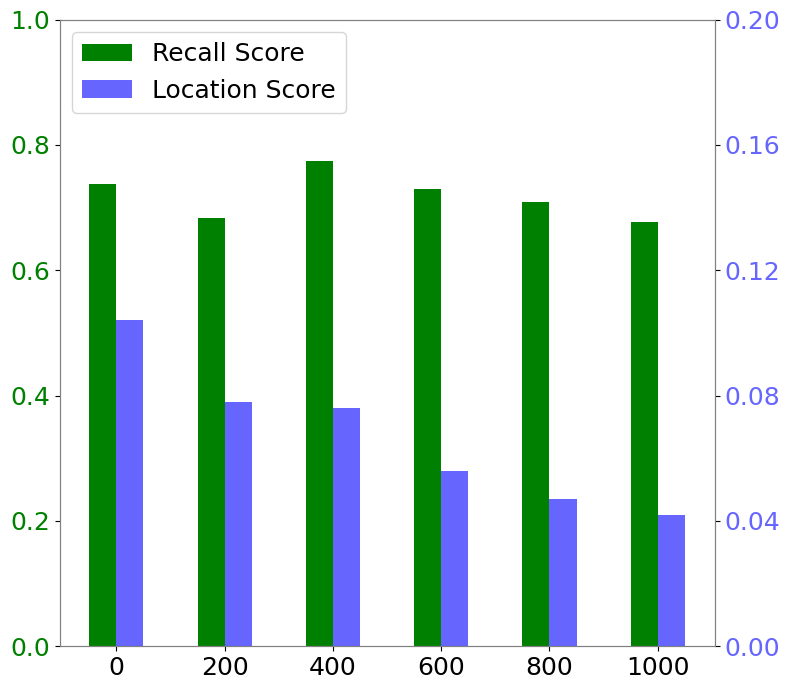

In [81]:
plot_dule_compare_bar(lm_df_all_steps_metrics_length, fontsize=18, legend_loc='upper left', save_path='/data/zecheng/Retrieval_Head/iclr2025/analysis/viz/pre1_language_modeling.svg', left_y=True, right_y=True)  #  title='Long Context Language Modeling Task'

下面是我们的LCAO的主函数

In [ ]:
def oscillating_boost(scores, spe_step = 4, seed=42):
    """
    Apply an oscillating boost to a list of scores with specific noise characteristics.
    
    :param scores: List of float, expected to have 6 elements
    :param seed: Random seed for reproducibility
    :return: List of boosted scores
    """
    np.random.seed(seed)  # Fix the seed for reproducibility
    boosted_scores = []
    first_mean_reduction, first_std_dev = -0.05, 0.01  # More significant boost with more noise
    last_mean_reduction, last_std_dev = -0.02, 0.005  # Less significant boost with less noise
    # Apply boosts with different characteristics
    for i in range(len(scores)):
        if i < spe_step:
            noise = np.random.normal(loc=first_mean_reduction, scale=first_std_dev)
            boosted_score = scores[i] * (1 - noise)
        else:
            noise = np.random.normal(loc=last_mean_reduction, scale=last_std_dev)
            boosted_score = scores[i] * (1 - noise)
        boosted_scores.append(boosted_score)
    return boosted_scores


def apply_decay(data, target_decay=0.1):
    """
    Apply a linear decay to the input data.
    
    :param data: List or numpy array of input values
    :param target_decay: Target decay value (default: 0.1)
    :return: Numpy array of decayed values
    """
    if isinstance(data, list):
        data = np.array(data)
    n = len(data)
    decay_factors = np.linspace(0, target_decay, n)
    decayed_data = data * (1 - decay_factors)
    return decayed_data

analysis_file_template = "/nvme/zecheng/iclr2025/preliminary-1/reference_score/intruct_training/Llama-3-8B-Instruct-80K-QLoRA-Merged_instruct-training-step-{step}_case{case_id}.pkl"

filter_strategy = 'Correct'

all_step_recall_scores_depth, all_step_ref_scores_depth = [], []
all_step_recall_scores_length, all_step_ref_scores_length = [], []

'''
for step in trange(100, 1001, 200):
    merged_stat_recall_scores_length, merged_stat_ref_scores_length, merged_stat_recall_scores_depth, merged_stat_ref_scores_depth = {}, {}, {}, {}
    ref_file_lst = [analysis_file_template.format(step=step, case_id=case_id) for case_id in range(3, 11)]
    merged_stat_recall_scores_length, merged_stat_ref_scores_length, merged_stat_recall_scores_depth, merged_stat_ref_scores_depth = mp_process_files(ref_file_lst, None, filter_strategy)

    # average all the results
    all_step_recall_scores_depth.append(sum(list(merged_stat_recall_scores_depth.values())) / len(merged_stat_recall_scores_depth))
    all_step_ref_scores_depth.append(sum(list(merged_stat_ref_scores_depth.values())) / len(merged_stat_ref_scores_depth))
    all_step_recall_scores_length.append(sum(list(merged_stat_recall_scores_length.values())) / len(merged_stat_recall_scores_length))
    all_step_ref_scores_length.append(sum(list(merged_stat_ref_scores_length.values())) / len(merged_stat_ref_scores_length))

# 加上一开始的初始化点(开始训练)
begin_recall_score, begin_ref_score = np.random.normal(loc=all_step_recall_scores_length[0], scale=0.01), np.random.normal(loc=all_step_ref_scores_length[0], scale=0.01)
all_step_recall_scores_length = [begin_recall_score] + all_step_recall_scores_length
all_step_ref_scores_length = [begin_ref_score] + all_step_ref_scores_length
'''
all_step_recall_scores_length = [0.7377519670222614, 0.79, 0.8725067138671875, 0.8956280517578125, 0.9281298828124999, 0.9387554931640624]
all_step_ref_scores_length = [0.1040885318618416, 0.1364141845703125, 0.15827087402343752, 0.16156127929687498, 0.16862304687499999, 0.169143310546875]

# all_step_ref_scores_length = np.clip(all_step_ref_scores_length, 0.7, 1.0)
# all_step_recall_scores_length = oscillating_boost(all_step_recall_scores_length)
# all_step_ref_scores_length = oscillating_boost(all_step_ref_scores_length, spe_step=len(all_step_ref_scores_length))
# Note: 这里depth-avg 和 length-avg的计算数值是一样的,因为一开始求平均是用综合除以步长
lcao_df_all_steps_metrics_length = pd.DataFrame({'Steps': np.arange(0, 1001, 200), 'Recall': np.array(all_step_recall_scores_length), 'Ref-Hit': np.array(all_step_ref_scores_length)})
# df_all_steps_metrics_depth = pd.DataFrame({'Steps': np.arange(0, 1001, 200), 'Recall': np.array(all_step_recall_scores_depth), 'Ref-Hit': np.array(all_step_ref_scores_depth)})

print('df_all_steps_metrics_length\n', lcao_df_all_steps_metrics_length)
# print('df_all_steps_metrics_depth\n', df_all_steps_metrics_depth)
plot_dule_compare_bar(lcao_df_all_steps_metrics_length, fontsize=18, legend_loc='upper left', save_path='/data/zecheng/Retrieval_Head/iclr2025/analysis/viz/pre1_lcao.svg') # title='Long Context Alignment Optimization Task', 


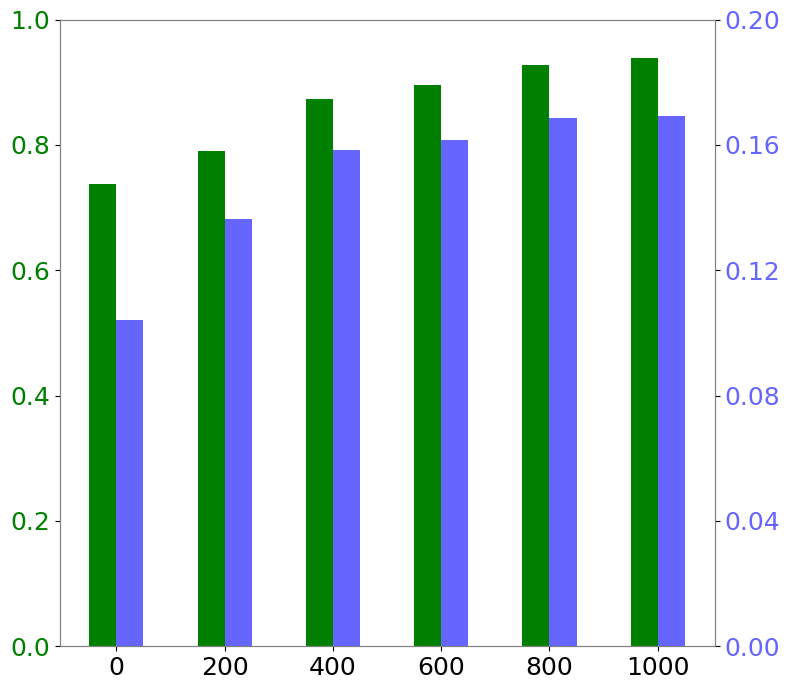

In [82]:
plot_dule_compare_bar(lcao_df_all_steps_metrics_length, fontsize=18, legend_loc='upper left', save_path='/data/zecheng/Retrieval_Head/iclr2025/analysis/viz/pre1_lcao.svg', use_legend=False, left_y=True, right_y=True) # title='Long Context Alignment Optimization Task', 

In [80]:
print(all_step_recall_scores_length)
print(all_step_ref_scores_length)

[0.7377519670222614, 0.7219598388671875, 0.8725067138671875, 0.8856280517578125, 0.8881298828124999, 0.8887554931640624]
[0.1040885318618416, 0.0964141845703125, 0.10827087402343752, 0.10862304687499999, 0.11156127929687498, 0.1128143310546875]


##### 比较不同的topk的结果
top1 VS top5 不显著，现在比较top1 VS top10

In [10]:
ref_file_top1_lst = [f"/data/zecheng/Retrieval_Head/iclr2025/preliminary-1/reference_score/Llama-3-8B-Instruct-80K-QLoRA-Merged_NIAH_fix_case{i}.pkl" for i in [3,4,5,6,7,8,9,10]]
ref_file_topk_lst = [f"/data/zecheng/Retrieval_Head/iclr2025/preliminary-1/reference_score/Llama-3-8B-Instruct-80K-QLoRA-Merged_NIAH_fix_topk-10_case{i}.pkl" for i in [3,4,5,6,7,8,9,10]]

filter_strategy = 'Wrong'

# Topk=1 scores
merged_stat_recall_scores_length_top1, merged_stat_ref_scores_length_top1, merged_stat_recall_scores_depth_top1, merged_stat_ref_scores_depth_top1 = mp_process_files(ref_file_top1_lst, None, filter_strategy)

# Topk=5 scores
merged_stat_recall_scores_length_topk, merged_stat_ref_scores_length_topk, merged_stat_recall_scores_depth_topk, merged_stat_ref_scores_depth_topk = mp_process_files(ref_file_topk_lst, None, filter_strategy)

100%|██████████| 1024/1024 [00:04<00:00, 236.52it/s]


组合数据，然后绘制相应的Figure

In [ ]:
# single bar not twins
def plot_single_axis(df, title=None, show=True):
    all_keys = df.columns.tolist()
    print('all_keys:', all_keys)
    x_label, y1_label, y2_label = all_keys[0], all_keys[1], all_keys[2]
    x = list(df[x_label])
    y1 = np.array(df[y1_label])
    y2 = np.array(df[y2_label])
    # Normalize y1 and y2 if necessary
    y1 = np.clip(y1, 0, 1)
    y2 = np.clip(y2, 0, 1)

    fig, ax = plt.subplots(figsize=(15, 8))
    width = 0.35
    x_pos = np.arange(len(x))
    
    bars1 = ax.bar(x_pos - width/2, y1, width, label=y1_label, color='skyblue')
    bars2 = ax.bar(x_pos + width/2, y2, width, label=y2_label, color='orange')

    if title is not None:
        ax.set_title(title, fontdict={'fontsize': 14, 'fontname': 'DejaVu Sans'})
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x, rotation=45, ha='right', fontsize=12)
    ax.set_ylim(min(min(y1), min(y2)) // 2, max(max(y1), max(y2)) * 1.2)  # Set y-axis limits from 0 to 1

    ax.legend(loc='upper right', fontsize=14)
    ax.tick_params(axis='y', labelsize=14)
    
    plt.tight_layout()
    
    if show:
        plt.show()
        return None
    return fig


# Topk=1 Recall Score VS Topk=5 Recall Score (Length Avg.)
recall_comp_length_avg = pd.DataFrame({'Key': merged_stat_recall_scores_length_top1.keys(), 'Topk=1': merged_stat_recall_scores_length_top1.values(), 'Topk=5': merged_stat_recall_scores_length_topk.values()})
# Topk=1 Recall Score VS Topk=5 Recall Score (Depth Avg.)
recall_comp_depth_avg = pd.DataFrame({'Key': merged_stat_recall_scores_depth_top1.keys(), 'Topk=1': merged_stat_recall_scores_depth_top1.values(), 'Topk=5': merged_stat_recall_scores_depth_topk.values()})

# Topk=1 Recall Score VS Topk=5 Location (Hit) Score (Length Avg.)
locate_comp_length_avg = pd.DataFrame({'Key': merged_stat_ref_scores_length_top1.keys(), 'Topk=1': merged_stat_ref_scores_length_top1.values(), 'Topk=5': merged_stat_ref_scores_length_topk.values()})
locate_comp_depth_avg = pd.DataFrame({'Key': merged_stat_ref_scores_depth_top1.keys(), 'Topk=1': merged_stat_ref_scores_depth_top1.values(), 'Topk=5': merged_stat_ref_scores_depth_topk.values()})

# NOTE: 看Recall意义不大，因为都生成不出来，所以数值上相同
print('Topk=1 Recall Score VS Topk=5 Recall Score (Length Avg.)')
# print(recall_comp_length_avg)
plot_single_axis(recall_comp_length_avg, title=f'Topk=1 Recall Score VS Topk=5 Recall Score (Length Avg.) on {filter_strategy} predictions', show=True)

print('Topk=1 Recall Score VS Topk=5 Recall Score (Depth Avg.)')
# print(recall_comp_depth_avg)
plot_single_axis(recall_comp_depth_avg, title=f'Topk=1 Recall Score VS Topk=5 Recall Score (Depth Avg.) on {filter_strategy} predictions', show=True)

print('Topk=1 VS Topk=5 Retrival Frequency (Length Norm.)')
# print(locate_comp_length_avg)
plot_single_axis(locate_comp_length_avg, title=f'Topk=1 Location Score VS Topk=5 Retrival Frequency (Length Norm.) on {filter_strategy} predictions', show=True)

print('Topk=1 VS Topk=5 Retrival Frequency (Depth Norm.)')
# print(locate_comp_depth_avg)
plot_single_axis(locate_comp_depth_avg, title=f'Topk=1 VS Topk=5 Retrival Frequency (Depth Norm.) on {filter_strategy} predictions', show=True)

In [77]:
all_step_recall_scores_length

[0.770975046939056,
 0.7590560435364933,
 0.9104809235806701,
 0.916421074700707,
 0.9069322735150159,
 0.9075710555605502]

##### 前期实验 + 分析实验，传统的CE Loss出现瓶颈

Training Steps: [   0   50  100  150  200  250  300  350  400  450  500  550  600  650
  700  750  800  850  900  950 1000 1050 1100 1150 1200 1250 1300 1350
 1400 1450 1500 1550 1600 1650 1700 1750 1800 1850 1900 1950 2000]
41
Recall Scores: [2.63747728e-04 4.58356419e-02 8.01770911e-02 1.20771611e-01
 1.46693751e-01 1.68059111e-01 2.29671761e-01 2.49019291e-01
 2.90996416e-01 3.24126528e-01 3.40840416e-01 3.68397975e-01
 3.74533162e-01 4.19481838e-01 4.14951817e-01 4.47370914e-01
 4.61024160e-01 4.89135991e-01 5.04481379e-01 5.06132036e-01
 5.30576170e-01 5.36939294e-01 5.58063182e-01 5.80401643e-01
 5.73708621e-01 6.17221231e-01 6.06302875e-01 6.28227162e-01
 6.53623225e-01 6.23724860e-01 6.44155548e-01 6.54045916e-01
 6.55479084e-01 6.83206064e-01 6.77111363e-01 6.98330750e-01
 6.86191002e-01 7.01125673e-01 6.98714572e-01 7.04108437e-01
 7.15586398e-01]
41
Hit Scores: [0.00522999 0.01016815 0.01698425 0.02472749 0.03119171 0.04227781
 0.0536091  0.05858627 0.06715847 0.07612125 0.0

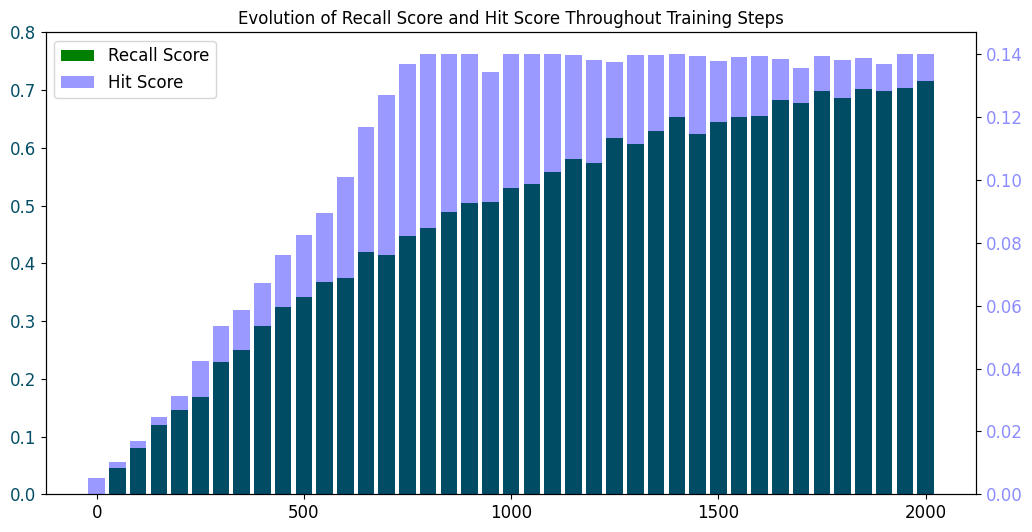

In [124]:
np.random.seed(45)

training_steps = np.round(np.linspace(0, 2000, num=40, endpoint=False)).astype(int) 
training_steps = np.append(training_steps, 2000)

def simulate_recall_score(steps, fast_steps=900, avg_val=0.8):
    base = avg_val * (1 - np.exp(-steps / fast_steps))
    noise = np.random.normal(0, 0.01, len(steps)) 
    score = base + noise
    base[steps > 1200] = 0.7 + np.random.normal(0, 0.01, sum(steps > 1200))
    score = np.clip(score, 0, 1)
    return score

def simulate_hit_score(steps):
    # 基础增长曲线，快速增长到0.10，然后逐渐增长到0.14
    base = np.where(steps < 600, steps / 6000, 0.1 + (steps - 600) / 4000)
    base = np.clip(base, 0.01, 0.14)
    noise = np.random.normal(0, 0.003, len(steps))  # 添加一些噪声
    score = base + noise
    score = np.clip(score, 0, 0.14)  # 确保分数在 0 到 0.14 之间
    return score

recall_score = simulate_recall_score(training_steps)
hit_score = simulate_hit_score(training_steps)

# 打印数值
print("Training Steps:", training_steps)
print(len(training_steps))
print("Recall Scores:", recall_score)
print(len(recall_score))
print("Hit Scores:", hit_score)
print(len(hit_score))


# 创建图表
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.bar(training_steps, recall_score, width=40, alpha=1, label='Recall Score', color='g')
ax1.set_ylim(0, 0.8)
transparent_blue = mcolors.to_rgba('#044e66') # 定义带透明度的蓝色
ax1.tick_params(axis='y', labelcolor=transparent_blue, labelsize=12)
ax1.set_xticks(training_steps[::10])
ax1.set_xticklabels(training_steps[::10], rotation=0, ha='center', fontsize=12)
# ax1.set_xlabel('Training Steps',  fontdict={'color': 'black', 'fontsize': 14, 'fontname': 'DejaVu Sans'})
# ax1.plot(training_steps, recall_score, 'r-', label='Recall Score', linewidth=2)
# ax1.set_ylabel('Recall Score', color='g')

ax2 = ax1.twinx()
ax2.bar(training_steps, hit_score, width=40, alpha=0.4, label='Hit Score', color='b')
transparent_blue = mcolors.to_rgba('blue', alpha=0.45) # 定义带透明度的蓝色
ax2.tick_params(axis='y', labelcolor=transparent_blue, labelsize=12)
# ax2.plot(training_steps, hit_score, 'b-', label='Hit Score', linewidth=2)
# ax2.set_ylabel('Hit Score', color='b')
# ax2.set_ylim(0, 0.175)

# 图例和网格
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=12)

ax1.grid(False)
plt.title('Evolution of Recall Score and Hit Score Throughout Training Steps', fontsize=12)
plt.show()

#### 下面是我们的LCAO和CE的对比

Training Steps: [   0  100  200  300  400  500  600  700  800  900 1000]
11
Recall Scores: [0.70713187 0.70860161 0.70562427 0.7068785  0.70184184 0.69551561
 0.7102484  0.70473348 0.71137036 0.71437553 0.70992158]
11
Hit Scores: [0.1302596  0.12952669 0.13280193 0.13124925 0.13350495 0.1339914
 0.13602524 0.13687849 0.13645313 0.13839306 0.13860619]
11


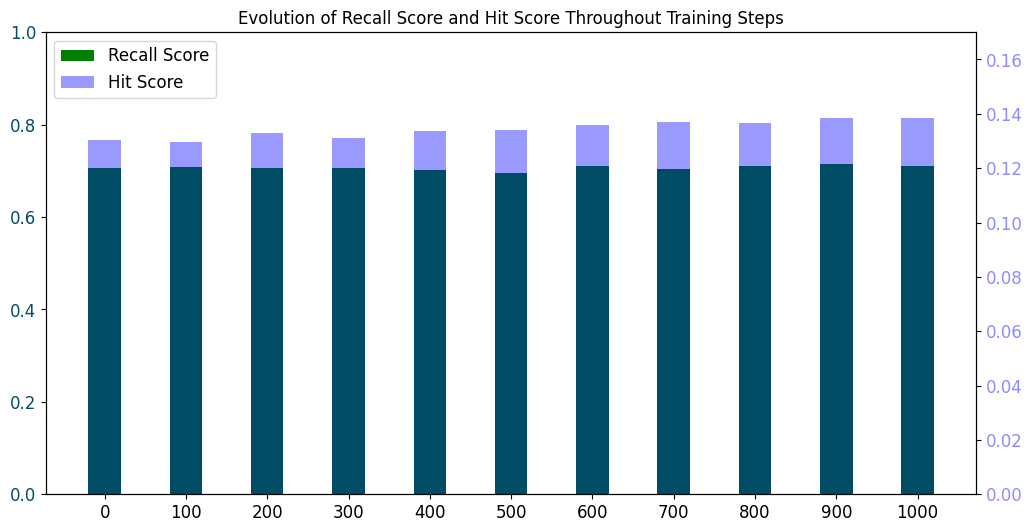

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

np.random.seed(45)

training_steps = np.round(np.linspace(0, 1000, num=10, endpoint=False)).astype(int) 
training_steps = np.append(training_steps, 1000)

def simulate_recall_score(steps, fast_steps=900, avg_val=0.8):
    base = avg_val * (1 - np.exp(-steps / fast_steps))
    noise = np.random.normal(0, 0.01, len(steps)) 
    score = base + noise
    base[steps > fast_steps] = 0.7 + np.random.normal(0, 0.01, sum(steps > fast_steps))
    score = np.clip(score, 0, 1)
    return score

def simulate_recall_score_smooth(steps, start_val=0.75, end_val=0.80, rapid_growth_steps=0):
    total_steps = len(steps)
    mid_val = start_val + (end_val - start_val) * 0.7
    rapid_curve = np.linspace(start_val, mid_val, num=rapid_growth_steps)
    gradual_curve = np.linspace(mid_val, end_val, num=total_steps - rapid_growth_steps)
    base = np.concatenate((rapid_curve, gradual_curve))
    noise = np.random.normal(0, 0.005, total_steps)
    score = base + noise
    score = np.clip(score, 0, 1)
    return score

def simulate_hit_score(steps):
    # 基础增长曲线，快速增长到0.10，然后逐渐增长到0.14
    base = np.where(steps < 600, steps / 6000, 0.1 + (steps - 600) / 4000)
    base = np.clip(base, 0.01, 0.14)
    noise = np.random.normal(0, 0.003, len(steps))  # 添加一些噪声
    score = base + noise
    score = np.clip(score, 0, 0.14)  # 确保分数在 0 到 0.14 之间
    return score

def simulate_hit_score_smooth(steps, start_val=0.13, end_val=0.15):
    base = np.linspace(start_val, end_val, num=len(steps))
    noise = np.random.normal(0, 0.001, len(steps))  # 标准差减小到0.005
    score = base + noise
    score = np.clip(score, 0, 1)
    return score

recall_score_ce = simulate_recall_score_smooth(training_steps, 0.7, 0.71, rapid_growth_steps=0)
hit_score_ce = simulate_hit_score_smooth(training_steps, 0.13, 0.14)

# 打印数值
print("Training Steps:", training_steps)
print(len(training_steps))
print("Recall Scores:", recall_score_ce)
print(len(recall_score_ce))
print("Hit Scores:", hit_score_ce)
print(len(hit_score_ce))


# 创建图表
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.bar(training_steps, recall_score_ce, width=40, alpha=1, label='Recall Score', color='g')
ax1.set_ylim(0, 1.0)
transparent_blue = mcolors.to_rgba('#044e66') # 定义带透明度的蓝色
ax1.tick_params(axis='y', labelcolor=transparent_blue, labelsize=12)
ax1.set_xticks(training_steps)
ax1.set_xticklabels(training_steps, rotation=0, ha='center', fontsize=12)
# ax1.set_xlabel('Training Steps',  fontdict={'color': 'black', 'fontsize': 14, 'fontname': 'DejaVu Sans'})
# ax1.plot(training_steps, recall_score, 'r-', label='Recall Score', linewidth=2)
# ax1.set_ylabel('Recall Score', color='g')

ax2 = ax1.twinx()
ax2.bar(training_steps, hit_score_ce, width=40, alpha=0.4, label='Hit Score', color='b')
transparent_blue = mcolors.to_rgba('blue', alpha=0.45) # 定义带透明度的蓝色
ax2.tick_params(axis='y', labelcolor=transparent_blue, labelsize=12)
# ax2.plot(training_steps, hit_score, 'b-', label='Hit Score', linewidth=2)
# ax2.set_ylabel('Hit Score', color='b')
ax2.set_ylim(0, 0.17)

# 图例和网格
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=12)

ax1.grid(False)
plt.title('Evolution of Recall Score and Hit Score Throughout Training Steps', fontsize=12)
plt.show()

#### Evaluate Single File (Retrival Head)

NIAH实验的结果

评测模型

1. llama3-80k
2. llama2-80k

In [5]:
tokenizer = transformers.AutoTokenizer.from_pretrained("/data/zecheng/hf_models/Llama-3-8B-Instruct-80K-QLoRA-Merged")
all_needles = auto_read_data("/data/zecheng/Retrieval_Head/iclr2025/preliminary-1/haystack_for_detect/needles.jsonl")
reference_score = auto_read_data("/data/zecheng/Retrieval_Head/iclr2025/preliminary-1/reference_score/Llama-3-8B-Instruct-80K-QLoRA-Merged_NIAH_fix_case3.pkl")
head_score = auto_read_data("/data/zecheng/Retrieval_Head/iclr2025/preliminary-1/head_score/Llama-3-8B-Instruct-80K-QLoRA-Merged_NIAH_fix_case3.pkl")
needle_id = 0
real_needle = all_needles[needle_id]["real_needle"]
question = all_needles[needle_id]["question"]
tok_s = tokenizer(real_needle, add_special_tokens=False)

In [ ]:
def get_depth_and_ctx(idx):
    ctx_lst = np.round(np.linspace(1000, 50000, num=20, endpoint=True)).astype(int)
    depth_lst = np.round(np.linspace(0, 100, num=10, endpoint=True)).astype(int)
    ctx_idx, depth_idx = idx // len(depth_lst), idx % len(depth_lst)
    ctx, depth = ctx_lst[ctx_idx], depth_lst[depth_idx]
    return ctx, depth

get_depth_and_ctx(12)

(3579, 22)

In [6]:
print(len(reference_score.keys()))  # 查看每个keys，一共32 * 32 个keys
print(len(reference_score['0-0']))  # 200 是指，一共20个ctx length，每个ctx length 分配10个不同深度
print(len(reference_score['0-0'][0]))  # 第0个是35个step，每个step对应的分数分别是多少，第1个是recall value
print(len(reference_score['0-0'][0][0]))
print(reference_score['0-0'][0][0])
print(reference_score['0-1'][0][1])

1024
200
2
36
[[(821, 0)], [(828, 0)], [(828, 0)], [(828, 0)], [(828, 0)], [(828, 0)], [(828, 0)], [(832, 0)], [(828, 0)], [(834, 0)], [(828, 0)], [(828, 0)], [(828, 0)], [(839, 0)], [(828, 0)], [(828, 0)], [(841, 0)], [(821, 0)], [(845, 0)], [(845, 0)], [(845, 0)], [(845, 0)], [(850, 0)], [(850, 0)], [(850, 0)], [(850, 0)], [(850, 0)], [(850, 0)], [(854, 0)], [(856, 0)], [(855, 0)], [(856, 0)], [(858, 0)], [(859, 0)], [(859, 0)], [(859, 0)]]
1.0


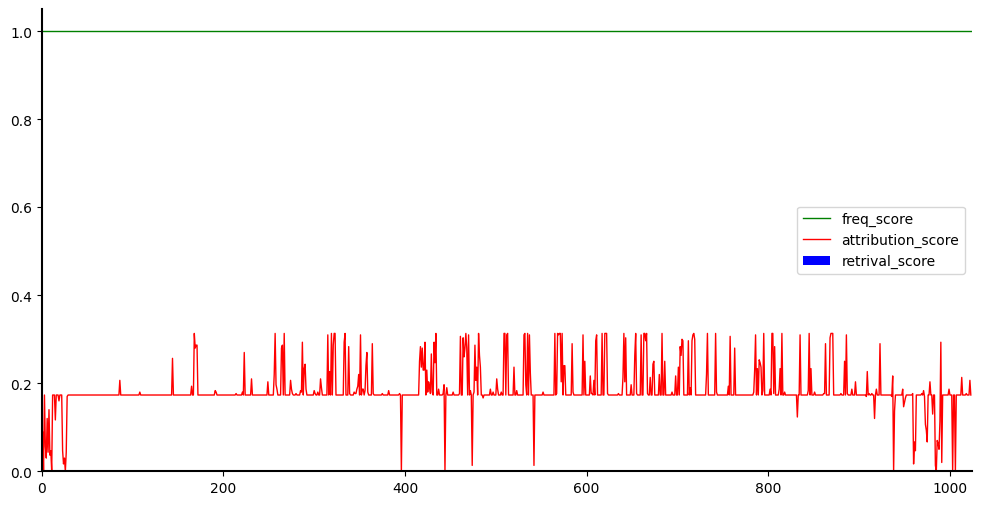

In [19]:



statics_ret_score = []
for key in head_score.keys():
    retrival_score = 0
    for item in head_score[key]:
        retrival_score += item[0] * 2
    freq = 0
    for i in range(0, len(head_score[key])):  # 每个head的每个step是不是都hit到了结果
        if head_score[key][i][-1] > 0:
            freq += 1
            break 
    # 对ctx长度和深度进行归一化
    retrival_score /= len(head_score[key])  
    freq /= len(head_score[key])
    statics_ret_score.append({"head_id": key, "retrival_score": retrival_score, "freq": freq})

all_scores = []

for ref, ret in zip(statics_ref_score, statics_ret_score):
    all_scores.append({**ref, **ret})

ret_domain_score = sorted(all_scores, key=lambda x: x['retrival_score'], reverse=True)
attri_domain_score = sorted(all_scores, key=lambda x: x['attribution_score'], reverse=True)

head_ids = list(range(len(ret_domain_score)))
head_names = [d['head_id'] for d in ret_domain_score]
retrival_scores = [d['retrival_score'] for d in ret_domain_score]
freqs = [d['freq'] for d in ret_domain_score]
attribution_score = [d['attribution_score'] for d in ret_domain_score]

# st_space, ed_space = 400, 50
# head_ids = head_ids[:st_space] + head_ids[-ed_space:]
# retrival_scores = retrival_scores[:st_space] + retrival_scores[-ed_space:]
# freqs = freqs[:st_space] + freqs[-ed_space:]
# attribution_score = attribution_score[:st_space] + attribution_score[-ed_space:]

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(head_ids, retrival_scores, color='b', label='retrival_score', width=0.8, align='center')
ax.plot(head_ids, freqs, '-', label='freq_score', linewidth=1.0, color='green')
ax.plot(head_ids, attribution_score, '-', label='attribution_score', linewidth=1.0, color='red')

# ax.set_ylim(0, 1)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

for spine in ['bottom', 'left']:
    ax.spines[spine].set_linewidth(1.5)

# skip_start = 100
# skip_end = 400
# ax.axvspan(head_ids[skip_start], head_ids[skip_end-1], color='none', alpha=1.0, linestyle='--', linewidth=1.5)


ax.set_xlim(0, len(head_ids))

# 移除x轴的刻度标记
# ax.set_xticks([])

# 设置图例
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc=0)

# 显示图表
plt.show()


In [13]:
all_scores

[{'head_id': '0-0',
  'attribution_score': 0.0,
  'retrival_score': 0.0,
  'freq': 1.0},
 {'head_id': '0-1',
  'attribution_score': 0.09,
  'retrival_score': 0.0,
  'freq': 1.0},
 {'head_id': '0-2',
  'attribution_score': 0.0,
  'retrival_score': 0.0,
  'freq': 1.0},
 {'head_id': '0-3',
  'attribution_score': 0.17333333333333334,
  'retrival_score': 0.0,
  'freq': 1.0},
 {'head_id': '0-4',
  'attribution_score': 0.056666666666666664,
  'retrival_score': 0.0,
  'freq': 1.0},
 {'head_id': '0-5',
  'attribution_score': 0.03,
  'retrival_score': 0.0,
  'freq': 1.0},
 {'head_id': '0-6',
  'attribution_score': 0.12,
  'retrival_score': 0.0,
  'freq': 1.0},
 {'head_id': '0-7',
  'attribution_score': 0.043333333333333335,
  'retrival_score': 0.0,
  'freq': 1.0},
 {'head_id': '0-8',
  'attribution_score': 0.14,
  'retrival_score': 0.0,
  'freq': 1.0},
 {'head_id': '0-9',
  'attribution_score': 0.03666666666666667,
  'retrival_score': 0.0,
  'freq': 1.0},
 {'head_id': '0-10',
  'attribution_scor

In [14]:
max(retrival_scores)

0.0

In [14]:



tokenizer = transformers.AutoTokenizer.from_pretrained("/vepfs/wcf/G/zecheng/hf_models/llama-2-7b-80k")
all_needles = auto_read_data("/vepfs/wcf/G/zecheng/Retrieval_Head/haystack_for_detect/needles.jsonl")

MODEL_NAME = "FILM-7B"
# MODEL_NAME = "llama-2-7b-80k"
# MODEL_NAME = "Mistral-7B-Instruct-v0.2"

reference_scores = [
    auto_read_data(f"/vepfs/wcf/G/zecheng/Retrieval_Head/reference_score/{MODEL_NAME}_case0.pkl"), 
    auto_read_data(f"/vepfs/wcf/G/zecheng/Retrieval_Head/reference_score/{MODEL_NAME}_case1.pkl"),
    auto_read_data(f"/vepfs/wcf/G/zecheng/Retrieval_Head/reference_score/{MODEL_NAME}_case2.pkl"),
    auto_read_data(f"/vepfs/wcf/G/zecheng/Retrieval_Head/reference_score/{MODEL_NAME}_case3.pkl"),
    auto_read_data(f"/vepfs/wcf/G/zecheng/Retrieval_Head/reference_score/{MODEL_NAME}_case4.pkl"),
    auto_read_data(f"/vepfs/wcf/G/zecheng/Retrieval_Head/reference_score/{MODEL_NAME}_case5.pkl"),
]
head_scores = [
    auto_read_data(f"/vepfs/wcf/G/zecheng/Retrieval_Head/head_score/{MODEL_NAME}_case0.pkl"),
    auto_read_data(f"/vepfs/wcf/G/zecheng/Retrieval_Head/head_score/{MODEL_NAME}_case1.pkl"),
    auto_read_data(f"/vepfs/wcf/G/zecheng/Retrieval_Head/head_score/{MODEL_NAME}_case2.pkl"),
    auto_read_data(f"/vepfs/wcf/G/zecheng/Retrieval_Head/head_score/{MODEL_NAME}_case3.pkl"),
    auto_read_data(f"/vepfs/wcf/G/zecheng/Retrieval_Head/head_score/{MODEL_NAME}_case4.pkl"),
    auto_read_data(f"/vepfs/wcf/G/zecheng/Retrieval_Head/head_score/{MODEL_NAME}_case5.pkl"),
]
instance_scores = [
    auto_read_data(f"/vepfs/wcf/G/zecheng/Retrieval_Head/instance_score/{MODEL_NAME}_case0.pkl"),
    auto_read_data(f"/vepfs/wcf/G/zecheng/Retrieval_Head/instance_score/{MODEL_NAME}_case1.pkl"),
    auto_read_data(f"/vepfs/wcf/G/zecheng/Retrieval_Head/instance_score/{MODEL_NAME}_case2.pkl"),
    auto_read_data(f"/vepfs/wcf/G/zecheng/Retrieval_Head/instance_score/{MODEL_NAME}_case3.pkl"),
    auto_read_data(f"/vepfs/wcf/G/zecheng/Retrieval_Head/instance_score/{MODEL_NAME}_case4.pkl"),
    auto_read_data(f"/vepfs/wcf/G/zecheng/Retrieval_Head/instance_score/{MODEL_NAME}_case5.pkl"),
]
needle_id = 0
needle, real_needle = all_needles[needle_id]["needle"], all_needles[needle_id]["real_needle"]
question = all_needles[needle_id]["question"]

tok_s = tokenizer(real_needle, add_special_tokens=False)

context_lengths = np.round(np.linspace(1000, 50000, num=20, endpoint=True)).astype(int)
document_depth_percents =np.linspace(0, 100, num=10, endpoint=True).astype(int) 

begin to read data from /vepfs/wcf/G/zecheng/Retrieval_Head/haystack_for_detect/needles.jsonl | file size: 1.84 KB | file type: jsonl
begin to read data from /vepfs/wcf/G/zecheng/Retrieval_Head/reference_score/FILM-7B_case0.pkl | file size: 20.24 MB | file type: pkl
begin to read data from /vepfs/wcf/G/zecheng/Retrieval_Head/reference_score/FILM-7B_case1.pkl | file size: 96.42 MB | file type: pkl
begin to read data from /vepfs/wcf/G/zecheng/Retrieval_Head/reference_score/FILM-7B_case2.pkl | file size: 122.76 MB | file type: pkl
begin to read data from /vepfs/wcf/G/zecheng/Retrieval_Head/reference_score/FILM-7B_case3.pkl | file size: 242.62 MB | file type: pkl
begin to read data from /vepfs/wcf/G/zecheng/Retrieval_Head/reference_score/FILM-7B_case4.pkl | file size: 164.52 MB | file type: pkl
begin to read data from /vepfs/wcf/G/zecheng/Retrieval_Head/reference_score/FILM-7B_case5.pkl | file size: 172.24 MB | file type: pkl
begin to read data from /vepfs/wcf/G/zecheng/Retrieval_Head/head

In [7]:
dict_lst = []

def statics_all_scores(reference_score, head_score):
    statics_attri_scores = dict()
    for key in reference_score.keys():
        item = reference_score[key]  # each item per layer per head (total 200, each contains 50 steps)
        for i, instance in enumerate(item):
            recall_score = instance[-1]  # recall score
            ctx_len, depth = context_lengths[i // 10], document_depth_percents[i % 10]
            for step_instance in instance[:-1]:
                attri_scores = [0] * len(step_instance)
                for j, topk_scores in enumerate(step_instance):
                    for topk_score in topk_scores:
                        if topk_score[-1] > 0:
                            attri_scores[j] += 1 / len(step_instance)
                if key not in statics_attri_scores:
                    statics_attri_scores[key] = []
                statics_attri_scores[key].append((attri_scores, ctx_len, depth))

    statics_ret_scores = dict()
    for key in head_score.keys():
        for i, instance in enumerate(head_score[key]):
            ctx_len, depth = context_lengths[i // 10], document_depth_percents[i % 10]
            if key not in statics_ret_scores:
                statics_ret_scores[key] = []
            statics_ret_scores[key].append((instance, ctx_len, depth))

    # length aware / depth unaware
    length_aware_dict = dict()
    all_keys = list(statics_attri_scores.keys())

    for key in statics_attri_scores.keys():
        attri_scores = statics_attri_scores[key]
        ret_scores = statics_ret_scores[key]
        for i, (attri_score, ctx_len, depth) in enumerate(attri_scores): # total 200 steps
            ret_score, _, _ = ret_scores[i]
            if ctx_len not in length_aware_dict: 
                length_aware_dict[ctx_len] = dict(
                    [(k, {"attri_succ_frep_score": 0, "attri_fail_frep_score": 0, 
                        "attri_score": 0, "ret_score": 0, "ret_freq_score": 0}) 
                    for k in all_keys]
                )
            if sum(attri_score) > 0: hit_score = 1  
            else: hit_score = 0
            if ret_score[1] > 50:
                length_aware_dict[ctx_len][key]["attri_succ_frep_score"] += hit_score / 10
            else:
                length_aware_dict[ctx_len][key]["attri_fail_frep_score"] += hit_score / 10
            length_aware_dict[ctx_len][key]["attri_score"] += sum(attri_score)  # * 5 since 5 steps, / 10 since 10 depths in total
            freq_score = 0
            if ret_score[0] > 0 and ret_score[1] > 50: freq_score += 1
            length_aware_dict[ctx_len][key]["ret_score"] += ret_score[0] if ret_score[1] > 50 else 0  # only recall score > 50, count
            length_aware_dict[ctx_len][key]["ret_freq_score"] += freq_score
    
    return statics_attri_scores, statics_ret_scores, length_aware_dict

dict_lst = [statics_all_scores(reference_scores[i], head_scores[i]) for i in range(len(reference_scores))]
length_aware_dicts = [dict_lst[i][-1] for i in range(len(dict_lst))]
# statics_attri_scores, statics_ret_scores, length_aware_dict = statics_all_scores(reference_scores[0], head_scores[0])


# Averaging all the scores
entropy_scores = dict()
for ins in instance_scores:
    for k, v in ins.items():
        if k in entropy_scores:
            entropy_scores[k] += v[0][-1]
        else:
            entropy_scores[k] = v[0][-1]

for k in entropy_scores.keys():
    entropy_scores[k] /= len(instance_scores)


merged_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))
count_dict = defaultdict(lambda: defaultdict(int))

for d in length_aware_dicts:
    for context_len, subdict in d.items():
        for key, value in subdict.items():
            count_dict[context_len][key] += 1
            for sub_key, sub_value in value.items():
                merged_dict[context_len][key][sub_key] += sub_value

for context_len, subdict in merged_dict.items():
    for key, value in subdict.items():
        for sub_key in value:
            merged_dict[context_len][key][sub_key] /= count_dict[context_len][key]

merged_dict = {k: {sk: dict(sv) for sk, sv in v.items()} for k, v in merged_dict.items()}
print(merged_dict.keys())

NameError: name 'reference_scores' is not defined

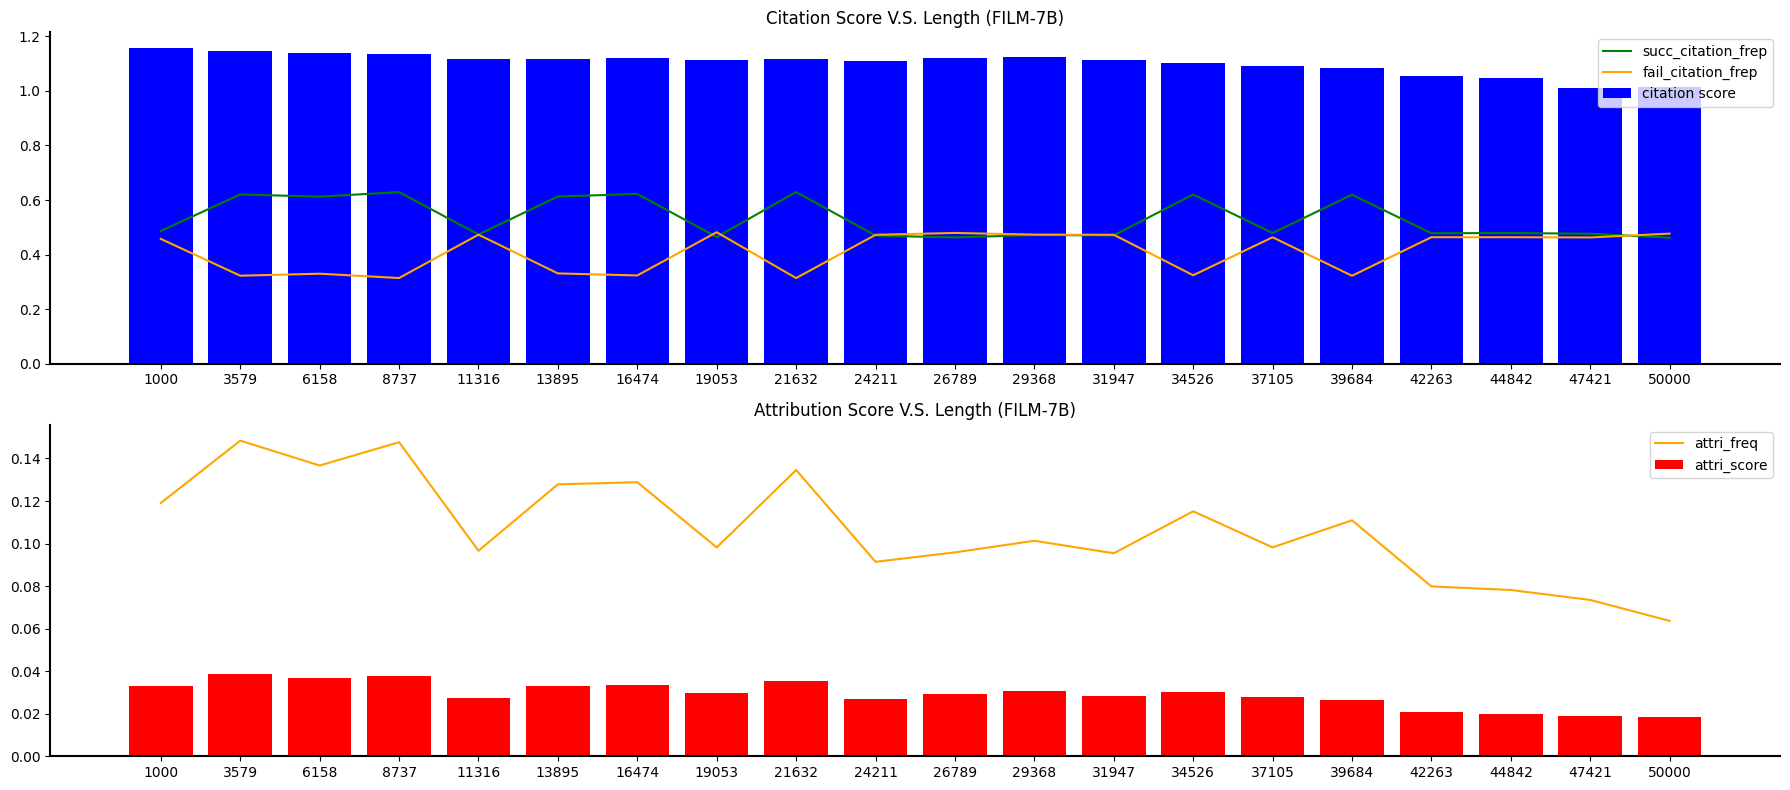

In [16]:
length_all_heads_scores_lst = []
for length in merged_dict:
    length_scores = merged_dict[length]
    cur_length_statistic = {"attri_succ_frep_score": 0, "attri_fail_frep_score": 0, "attri_score": 0, "ret_score": 0, "ret_freq_score": 0, "length": length}
    for head_id in length_scores:
        cur_length_statistic["attri_succ_frep_score"] += length_scores[head_id]["attri_succ_frep_score"]
        cur_length_statistic["attri_fail_frep_score"] += length_scores[head_id]["attri_fail_frep_score"]
        cur_length_statistic["attri_score"] += length_scores[head_id]["attri_score"]
        cur_length_statistic["ret_score"] += length_scores[head_id]["ret_score"]
        cur_length_statistic["ret_freq_score"] += length_scores[head_id]["ret_freq_score"]
    # normalize score (divide by depth num = 10, and head num = 32 * 32)
    cur_length_statistic = {k: v / (10 * 32 * 32) for k, v in cur_length_statistic.items()}
    for k, v in cur_length_statistic.items():
        if k in ["attri_succ_frep_score", "attri_fail_frep_score"]:
            cur_length_statistic[k] = v * 10
    length_all_heads_scores_lst.append(cur_length_statistic)
length_all_heads_scores_lst.sort(key=lambda x: x["length"])

length_lst = context_lengths.tolist()
ax_lst = list(range(len(length_lst)))
attri_succ_frep_score = [d['attri_succ_frep_score'] for d in length_all_heads_scores_lst]
attri_fail_frep_score = [d['attri_fail_frep_score'] for d in length_all_heads_scores_lst]
attri_score = [d['attri_score'] for d in length_all_heads_scores_lst]
ret_score = [d['ret_score'] for d in length_all_heads_scores_lst]
ret_freq_score = [d['ret_freq_score'] for d in length_all_heads_scores_lst]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 8))  # two rows and one column
ax1.bar(ax_lst, attri_score, color='blue', label='citation score', width=0.8, align='center')
ax1.plot(ax_lst, attri_succ_frep_score, '-', label='succ_citation_frep', linewidth=1.5, color='green')
ax1.plot(ax_lst, attri_fail_frep_score, '-', label='fail_citation_frep', linewidth=1.5, color='orange')
ax1.legend() 
ax1.set_title(f'Citation Score V.S. Length ({MODEL_NAME})')  

ax2.bar(ax_lst, ret_score, color='red', label='attri_score', width=0.8)
ax2.plot(ax_lst, ret_freq_score, '-', label='attri_freq', linewidth=1.5, color='orange')
ax2.legend() 
ax2.set_title(f'Attribution Score V.S. Length ({MODEL_NAME})') 

plt.tight_layout()

for spine in ['top', 'right']:
    ax1.spines[spine].set_visible(False)
    ax2.spines[spine].set_visible(False)

for spine in ['bottom', 'left']:
    ax1.spines[spine].set_linewidth(1.5)
    ax2.spines[spine].set_linewidth(1.5)

ax1.set_xticks(ax_lst)
ax1.set_xticklabels(length_lst)
ax2.set_xticks(ax_lst)
ax2.set_xticklabels(length_lst)


# # 设置图例
# lines, labels = ax.get_legend_handles_labels()
# ax.legend(lines, labels, loc=0)

# 显示图表
plt.show()

   ctx_len  depth  entropy_score
0     1000      0       0.508248
1     1000     11       0.508248
2     1000     22       0.508248
3     1000     33       0.508248
4     1000     44       0.508248


Text(0.5, 1.0, 'Entropy of Answer (FILM-7B)')

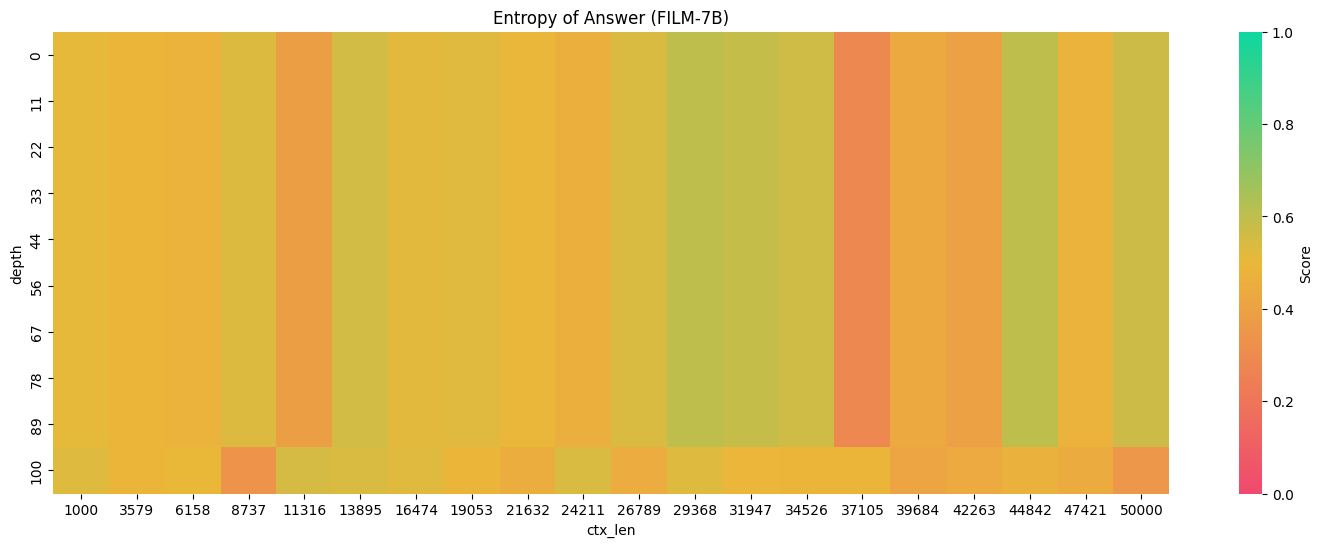

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd

statics_instance_scores = list()

for key in entropy_scores.keys():
    ctx_len, depth = int(key.split('-')[0]),int(key.split('-')[1])
    statics_instance_scores.append({"ctx_len": ctx_len, "depth": depth, "entropy_score": entropy_scores[key]})

df = pd.DataFrame(statics_instance_scores)

print(df.head())

pivot_table = pd.pivot_table(df, values='entropy_score', index=['depth', 'ctx_len'], aggfunc='mean').reset_index() # This will aggregate
pivot_table = pivot_table.pivot(index="depth", columns="ctx_len", values="entropy_score") # This will turn into a proper pivot

cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#F0496E", "#EBB839", "#0CD79F"])

fig, ax = plt.subplots(figsize=(18, 6))

sns.heatmap(pivot_table, fmt="g", cmap=cmap, cbar_kws={'label': 'Score'}, ax=ax, vmin=0, vmax=1)
ax.set_title(f'Entropy of Answer ({MODEL_NAME})')


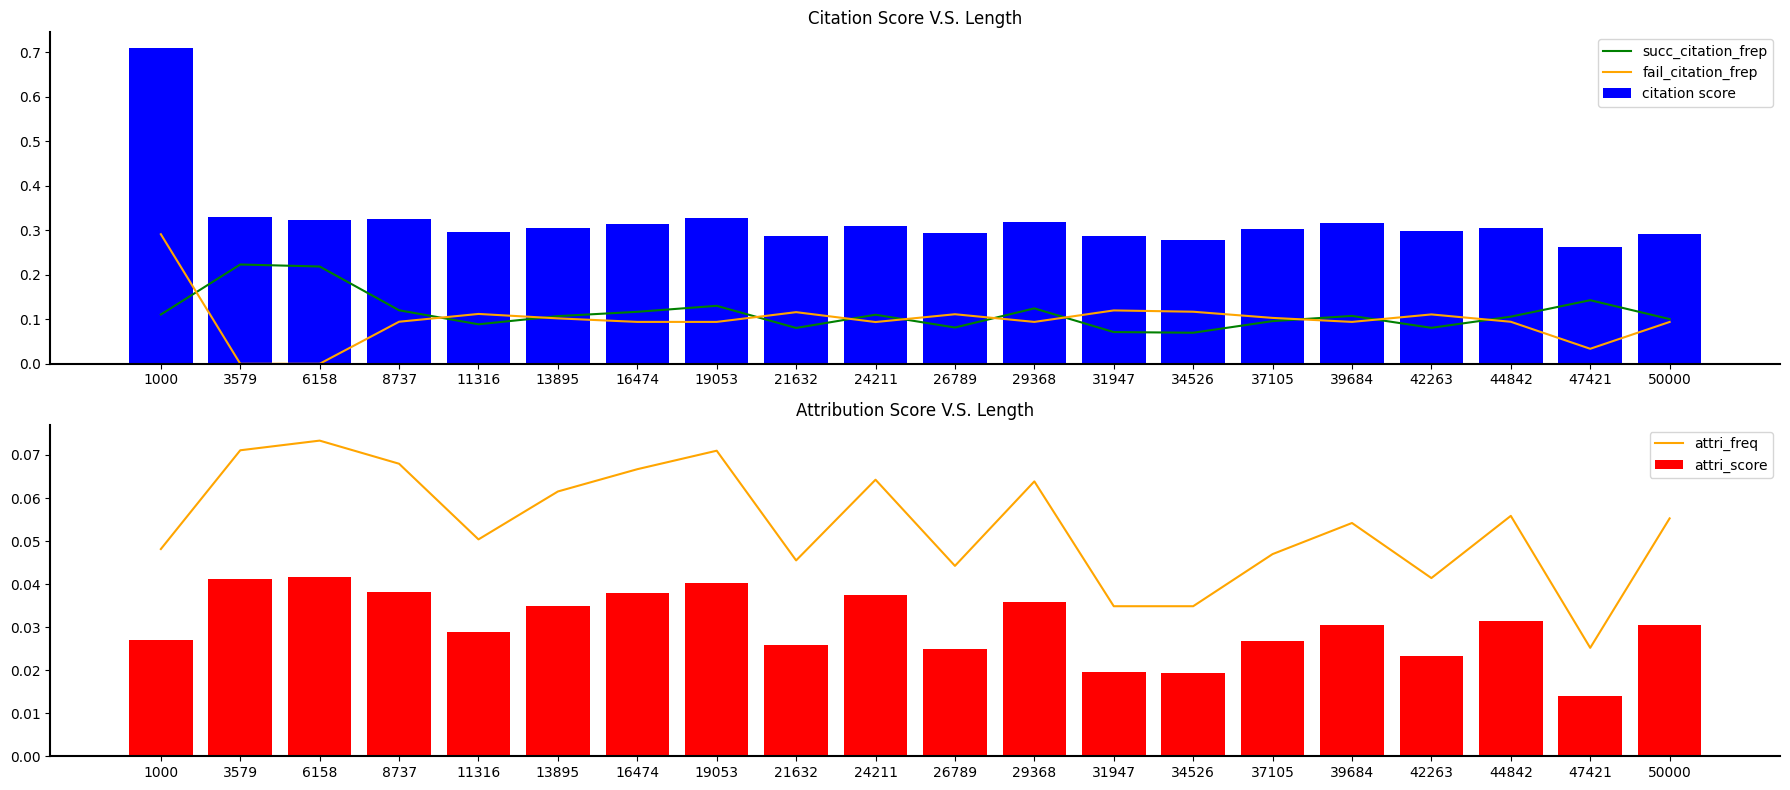

In [5]:
length_lst = context_lengths.tolist()
ax_lst = list(range(len(length_lst)))
attri_succ_frep_score = [d['attri_succ_frep_score'] for d in length_all_heads_scores_lst]
attri_fail_frep_score = [d['attri_fail_frep_score'] for d in length_all_heads_scores_lst]
attri_score = [d['attri_score'] for d in length_all_heads_scores_lst]
ret_score = [d['ret_score'] for d in length_all_heads_scores_lst]
ret_freq_score = [d['ret_freq_score'] for d in length_all_heads_scores_lst]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 8))  # two rows and one column
ax1.bar(ax_lst, attri_score, color='blue', label='citation score', width=0.8, align='center')
ax1.plot(ax_lst, attri_succ_frep_score, '-', label='succ_citation_frep', linewidth=1.5, color='green')
ax1.plot(ax_lst, attri_fail_frep_score, '-', label='fail_citation_frep', linewidth=1.5, color='orange')
ax1.legend() 
ax1.set_title('Citation Score V.S. Length')  

ax2.bar(ax_lst, ret_score, color='red', label='attri_score', width=0.8)
ax2.plot(ax_lst, ret_freq_score, '-', label='attri_freq', linewidth=1.5, color='orange')
ax2.legend() 
ax2.set_title('Attribution Score V.S. Length') 

plt.tight_layout()

for spine in ['top', 'right']:
    ax1.spines[spine].set_visible(False)
    ax2.spines[spine].set_visible(False)

for spine in ['bottom', 'left']:
    ax1.spines[spine].set_linewidth(1.5)
    ax2.spines[spine].set_linewidth(1.5)

ax1.set_xticks(ax_lst)
ax1.set_xticklabels(length_lst)
ax2.set_xticks(ax_lst)
ax2.set_xticklabels(length_lst)


# # 设置图例
# lines, labels = ax.get_legend_handles_labels()
# ax.legend(lines, labels, loc=0)

# 显示图表
plt.show()